In [6]:
!make docker-image > /dev/null 2>&1

In [7]:
!CONTAINER_CMD="bash -lc 'make install-ycsb'" make docker > /dev/null 2>&1

In [8]:
from pathlib import Path
import pexpect
import os
import time

""" Collector class has helper methods to interact with kermit"""
class Collector: 
    def __init__(self, config: Path):
        self.env = os.environ.copy()
        self.env["INTERACTIVE"] = "it"
        self.env["CONTAINER_CMD"] = f"bash -lc 'KERNMLOPS_CONFIG_FILE={config} make collect-data'"
        self.collect_process : pexpect.spawn | None = None

    def start_collection(self, logfile=None):
        self.collect_process = pexpect.spawn("make docker", env=self.env, timeout=None, logfile=logfile)
        self.collect_process.expect_exact(["Started benchmark"])

    def _after_run_generate_file_data() -> dict[str, list[Path]]:
        start_path : Path = Path("./data")
        list_of_collect_id_dirs = start_path.glob("*/*/*")
        latest_collect_id = max(list_of_collect_id_dirs, key=os.path.getctime)
        list_of_files = latest_collect_id.glob("*.*.parquet")
        output = {}
        for f in list_of_files:
            index = str(f).removeprefix(str(f.parent) + "/").split(".")[0]
            if index not in output.keys():
                output[index] = []
            output[index].append(f)
        return output
        
    def wait(self) -> int:
        if self.collect_process is None:
            return
        self.collect_process.expect([pexpect.EOF])
        self.collect_process.wait()
        return Collector._after_run_generate_file_data()
        
    def stop_collection(self):
        if self.collect_process is None:
            return
        self.collect_process.sendline("END")
        return self.wait()

There are two ways to run kermit:
- With the raw config
- With a pre-programmed benchmark config

In [11]:
import subprocess
import sys
collect = Collector("./config/raw_overrides.yaml")
# This creates a raw collector, I suggest looking into this file to learn more

w = open("hello.txt", "bw")
collect.start_collection(logfile=w)
print("Collection has started")
# Start collection

f = open("blah.txt", "w")
bench_test = subprocess.Popen(["cat", "defaults.yaml"], stdout=f)
bench_test.wait()
# Run benchmark application

print("Exit application")
raw_coll_info = collect.stop_collection()
print(raw_coll_info)
# Stop the Collector

Collection has started
Exit application
{'system_info': [PosixPath('data/curated/faux/0dbd3c32-4e54-4ac4-a9ff-b42405e70ed0/system_info.end.parquet')], 'file_data': [PosixPath('data/curated/faux/0dbd3c32-4e54-4ac4-a9ff-b42405e70ed0/file_data.end.parquet')], 'memory_usage': [PosixPath('data/curated/faux/0dbd3c32-4e54-4ac4-a9ff-b42405e70ed0/memory_usage.end.parquet')], 'process_metadata': [PosixPath('data/curated/faux/0dbd3c32-4e54-4ac4-a9ff-b42405e70ed0/process_metadata.end.parquet')], 'quanta_runtime': [PosixPath('data/curated/faux/0dbd3c32-4e54-4ac4-a9ff-b42405e70ed0/quanta_runtime.end.parquet')], 'quanta_queued_time': [PosixPath('data/curated/faux/0dbd3c32-4e54-4ac4-a9ff-b42405e70ed0/quanta_queued_time.end.parquet')], 'block_io': [PosixPath('data/curated/faux/0dbd3c32-4e54-4ac4-a9ff-b42405e70ed0/block_io.end.parquet')], 'dtlb_misses': [PosixPath('data/curated/faux/0dbd3c32-4e54-4ac4-a9ff-b42405e70ed0/dtlb_misses.end.parquet')], 'itlb_misses': [PosixPath('data/curated/faux/0dbd3c32-4e5

Now let's try to examine some of the system information from this.
I use polars, you can use whatever you like as far as data frames go, so long as they can read parquet files.

In [99]:
import polars as pl
from pathlib import Path
from plotnine import ggplot, aes, geom_line, geom_point, labs

def filter_process_trace(process_trace_df: pl.DataFrame) -> pl.DataFrame :
    df = process_trace_df
    # Filter just the processes
    df = df.filter(pl.col("tgid") == pl.col("pid")).drop("collection_id")

    # Find the last name of each process
    start_df = df.sort(pl.col("ts_ns"), descending = True)
    helper_dict = {}
    for row in start_df.iter_rows():
        pid = row[0]
        comm = row[3]
        if pid in helper_dict.keys() or comm == "": 
            continue
        helper_dict[pid] = comm

    # Separate the start and end
    full_df = start_df.with_columns(pl.col("pid").map_elements(lambda x : helper_dict.get(x, ""), return_dtype=str).alias("full_name"))
    full_df = full_df.drop(["tgid", "name"])
    start_df = full_df.filter(pl.col("cap_type") == "start").rename({"ts_ns": "start_ns"}).drop("cap_type")
    end_df = full_df.filter(pl.col("cap_type") == "end").rename({"ts_ns": "end_ns"}).drop(["cap_type", "full_name"])

    # Join them to get the process table
    combined_df = start_df.join(end_df, "pid")
    return combined_df.with_columns((pl.col("end_ns") - pl.col("start_ns")).alias("duration"))

def process_trace_start_end_ts(process_trace_df: pl.DataFrame, proc_name: str, index: int) ->(int, int, int):
    trace_df = filter_process_trace(process_trace_df).sort(pl.col("start_ns"))
    df = trace_df.filter(pl.col("full_name") == proc_name)
    df = df[index]
    pid = df["pid"][0]
    start_ns = df["start_ns"][0]
    end_ns = df["end_ns"][0]
    return pid, start_ns, end_ns

def clean_rss_pid(rss_df: pl.DataFrame, pid: int) -> pl.DataFrame:
    df = rss_df.drop(["pid", "collection_id"]).sort(pl.col("ts_ns"))
    df = df.filter(pl.col("tgid") == pid)
    df = df.with_columns(pl.when(pl.col("member") == "MM_FILEPAGES")
                     .then(pl.col("count"))
                     .otherwise(None)
                     .fill_null(strategy="forward")
                     .fill_null(strategy="backward")
                     .alias("file"))
    df = df.with_columns(pl.when(pl.col("member") == "MM_ANONPAGES")
                     .then(pl.col("count"))
                     .otherwise(None)
                     .fill_null(strategy="forward")
                     .fill_null(strategy="backward")
                     .alias("anon"))
    df = df.with_columns(pl.when(pl.col("member") == "MM_SWAPENTS")
                     .then(pl.col("count"))
                     .otherwise(None)
                     .fill_null(strategy="forward")
                     .fill_null(strategy="backward")
                     .alias("swap"))
    df = df.drop(["member", "count"])
    zero_df = pl.DataFrame({"tgid": pid, "ts_ns" : -1, "file" : 0, "anon": 0, "swap": 0})
    df = pl.concat([df, zero_df]).sort("ts_ns")
    df = df.fill_null(strategy="forward")
    df = df.filter(pl.col("ts_ns") >= 0)
    df = df.with_columns((pl.col("file") + pl.col("anon") + pl.col("swap")).alias("count"))
    df = df.drop(["file", "anon", "swap"])
    return df
    
def filter_rss_with_ts(rss_trace_df: pl.DataFrame, start: int, end: int):
    new_frame_dict = {}
    for column_name in rss_trace_df.columns:
        new_frame_dict[column_name] = [None, None]
    new_frame_dict["ts_ns"] = [start, end]
    df = rss_trace_df.vstack(pl.DataFrame(new_frame_dict))
    df = df.sort(pl.col("ts_ns")).fill_null(strategy="forward").fill_null(strategy="backward")
    return df.filter(pl.col("ts_ns").is_between(start, end, closed='both'))

def get_proper_rss(proc_path: Path, rss_path: Path, rss_name: str, rss_ind: int, runner_name: str, runner_ind: int, tag: str):
    proc_trace_df = pl.read_parquet(proc_path)
    rss_df = pl.read_parquet(rss_path)

    _, start, end = process_trace_start_end_ts(proc_trace_df, runner_name, runner_ind)
    pid, _, _ = process_trace_start_end_ts(proc_trace_df, rss_name, rss_ind)
    clean_rss_df = filter_rss_with_ts(clean_rss_pid(rss_df, pid), start, end)
    return clean_rss_df.with_columns((pl.col("ts_ns") - pl.min("ts_ns")).alias("norm_ts_ns")).with_columns(pl.lit(tag).alias('policy'))

def create_rss_graph(inputs: [(str, dict[str, Path])], proc_tag: str, proc_ind: int, time_proc_tag: str, time_proc_index: int, title: str) -> None:
    df = pl.DataFrame()
    for (tag, filedict) in inputs:
        append_df = get_proper_rss(filedict["process_trace"],
                                   filedict["mm_rss_stat"],
                                   proc_tag, proc_ind,
                                   time_proc_tag,
                                   time_proc_index,
                                   tag).drop(["tgid", "ts_ns"])
        df = pl.concat([df, append_df])
    df = df.with_columns((pl.col("norm_ts_ns") / (10**9)/ 60).alias("norm_ts_mins"))
    plt0 = (ggplot(df)
            + aes("norm_ts_mins", y="count", colour="policy")
            + geom_point()
            + geom_line()
            + labs(x="Time (mins)",
                   y="4kB Pages",
                   title=title)
           )
    return plt0

def filter_dtlb_with_ts(dtlb_trace_df: pl.DataFrame, start: int, end: int):
    start_us = start // 1000  # Convert ns to us
    end_us = end // 1000      # Convert ns to us
    
    print(f"Filtering DTLB data from {start_us} to {end_us} μs")
    print(f"DTLB data time range: {dtlb_trace_df['ts_uptime_us'].min()} to {dtlb_trace_df['ts_uptime_us'].max()} μs")
    print(f"DTLB data shape before filtering: {dtlb_trace_df.shape}")
    
    new_frame_dict = {}
    for column_name in dtlb_trace_df.columns:
        new_frame_dict[column_name] = [None, None]
    new_frame_dict["ts_uptime_us"] = [start_us, end_us]
    
    df = dtlb_trace_df.vstack(pl.DataFrame(new_frame_dict))
    df = df.sort(pl.col("ts_uptime_us")).fill_null(strategy="forward").fill_null(strategy="backward")
    
    filtered_df = df.filter(pl.col("ts_uptime_us").is_between(start_us, end_us, closed='both'))
    print(f"DTLB data shape after filtering: {filtered_df.shape}")
    
    if filtered_df.shape[0] > 0:
        print("Sample of filtered data (first 3 rows):")
        print(filtered_df.head(3))
        print("Sample of filtered data (last 3 rows):")
        print(filtered_df.tail(3))
    
    return filtered_df

def clean_dtlb_pid(dtlb_df: pl.DataFrame, pid: int) -> pl.DataFrame:
    # Drop unnecessary columns, but keep the ones we need
    df = dtlb_df.drop(["pid", "pmu_enabled_time_us", 
                     "pmu_running_time_us", "collection_id"])
    
    # Filter to only include rows for the specified process
    df = df.filter(pl.col("tgid") == pid)
    
    # Keep all CPUs, sort by timestamp and CPU
    df = df.sort(["ts_uptime_us", "cpu"])
    
    print(f"DTLB data for pid {pid}: {df.shape[0]} rows")
    
    return df

def get_proper_dtlb(proc_path: Path, dtlb_path: Path, dtlb_name: str, dtlb_ind: int, 
                   runner_name: str, runner_ind: int, tag: str):
    proc_trace_df = pl.read_parquet(proc_path)
    dtlb_df = pl.read_parquet(dtlb_path)
    
    _, start, end = process_trace_start_end_ts(proc_trace_df, runner_name, runner_ind)
    pid, _, _ = process_trace_start_end_ts(proc_trace_df, dtlb_name, dtlb_ind)
    
    # Basic processing - keep all CPUs
    clean_df = clean_dtlb_pid(dtlb_df, pid)
    filtered_df = filter_dtlb_with_ts(clean_df, start, end)
    
    if filtered_df.shape[0] == 0:
        # Return empty DataFrame with correct schema
        return pl.DataFrame({
            "ts_uptime_us": [],
            "cumulative_dtlb_misses": [],
            "tgid": [],
            "norm_ts_ns": [],
            "policy": []
        })
    
    # Get unique timestamps
    unique_ts = filtered_df.select("ts_uptime_us").unique().sort("ts_uptime_us")
    
    # Get unique CPUs
    unique_cpus = filtered_df.select("cpu").unique().sort("cpu")
    
    # For each CPU, fill missing timestamps with last observed value or 0
    cpu_dfs = []
    for cpu in unique_cpus["cpu"]:
        cpu_df = filtered_df.filter(pl.col("cpu") == cpu).select(["ts_uptime_us", "cumulative_dtlb_misses"])
        
        # Create a DataFrame with all unique timestamps for this CPU
        full_ts_df = unique_ts.join(cpu_df, on="ts_uptime_us", how="left")
        
        # Fill nulls with last observed value or 0 and ensure monotonic increase
        full_ts_df = full_ts_df.with_columns(
            pl.col("cumulative_dtlb_misses")
            .fill_null(strategy="forward")
            .fill_null(0)
            .cum_max()
            .alias("cumulative_dtlb_misses")
        ).with_columns(
            pl.lit(cpu).alias("cpu")
        )
        
        cpu_dfs.append(full_ts_df)
    
    # Combine all CPU DataFrames
    combined_df = pl.concat(cpu_dfs)
    
    # Sum DTLB misses across CPUs for each timestamp
    aggregated_df = combined_df.group_by("ts_uptime_us").agg(
        cumulative_dtlb_misses=pl.col("cumulative_dtlb_misses").sum()
    ).sort("ts_uptime_us")
    
    # Ensure strictly increasing misses
    aggregated_df = aggregated_df.with_columns(
        pl.col("cumulative_dtlb_misses").cum_max().alias("cumulative_dtlb_misses")
    )
    
    # Add normalized timestamps and policy
    min_ts = aggregated_df["ts_uptime_us"].min()
    result_df = aggregated_df.with_columns(
        ((pl.col("ts_uptime_us") - min_ts) * 1000).alias("norm_ts_ns"),
        pl.lit(pid).alias("tgid"),
        pl.lit(tag).alias("policy")
    )
    
    return result_df

def create_dtlb_graph(inputs: [(str, dict[str, Path])], proc_tag: str, proc_ind: int, 
                     time_proc_tag: str, time_proc_index: int, title: str) -> None:
    df = pl.DataFrame()
    for (tag, filedict) in inputs:
        print(f"\nProcessing policy: {tag}")
        append_df = get_proper_dtlb(filedict["process_trace"],
                                  filedict["dtlb_misses"],
                                  proc_tag, proc_ind,
                                  time_proc_tag,
                                  time_proc_index,
                                  tag).drop(["tgid", "ts_uptime_us"])
        df = pl.concat([df, append_df])
    
    print(f"Combined data: {df.shape[0]} rows")
    
    # Convert to minutes
    df = df.with_columns((pl.col("norm_ts_ns") / (10**9)/ 60).alias("norm_ts_mins"))
    
    plt0 = (ggplot(df)
           + aes("norm_ts_mins", y="cumulative_dtlb_misses", colour="policy")
           + geom_point()
           + geom_line()
           + labs(x="Time (mins)",
                 y="DTLB Misses (All CPUs)",
                 title=title)
          )
    return plt0

In [103]:
collect = Collector("./config/redis_never.yaml")
collect.start_collection(None)
redis_never_info = collect.wait()
collect = Collector("./config/redis_madvise.yaml")
collect.start_collection(None)
redis_madvise_info = collect.wait()
collect = Collector("./config/redis_always.yaml")
collect.start_collection(None)
redis_always_info = collect.wait()

In [104]:
from IPython.display import Image, display
plt = create_rss_graph([("4k", redis_never_info),
                    ("madvise", redis_madvise_info),
                    ("thp", redis_always_info)],
                   "redis-server", 0, 
                   "redis-server", 0,
                   "Redis driven by YCSB with Insertions and Deletes using Jemalloc")
plt.save("deletes-redis.png")

/home/anish/.local/share/virtualenvs/KernMLOps-qEOPCQS_/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/anish/.local/share/virtualenvs/KernMLOps-qEOPCQS_/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: deletes-redis.png


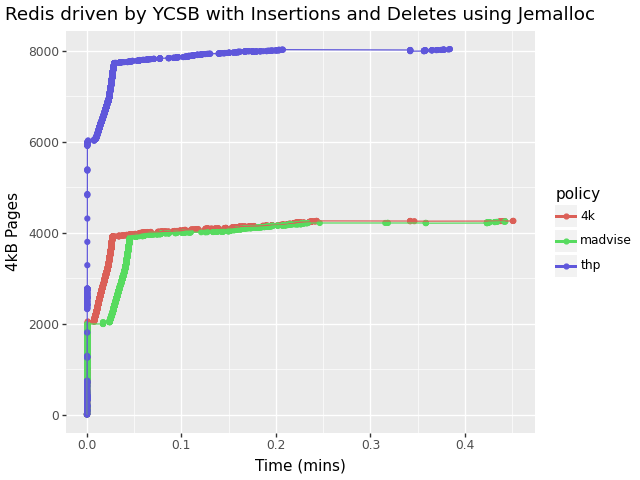

In [105]:
Image(filename="./deletes-redis.png")

In [106]:
from IPython.display import Image, display
plt = create_dtlb_graph([("4k", redis_never_info),
                    ("madvise", redis_madvise_info),
                    ("thp", redis_always_info)],
                   "redis-server", 0, 
                   "redis-server", 0,
                   "Redis driven by YCSB with Insertions and Deletes using Jemalloc")
plt.save("deletes-redis-dtlb.png")


Processing policy: 4k
DTLB data for pid 1281501: 4925 rows
Filtering DTLB data from 263924242908 to 263951304742 μs
DTLB data time range: 263924257512 to 263951306898 μs
DTLB data shape before filtering: (4925, 4)
DTLB data shape after filtering: (4924, 4)
Sample of filtered data (first 3 rows):
shape: (3, 4)
┌─────┬─────────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid    ┆ ts_uptime_us ┆ cumulative_dtlb_misses │
│ --- ┆ ---     ┆ ---          ┆ ---                    │
│ i64 ┆ i64     ┆ i64          ┆ i64                    │
╞═════╪═════════╪══════════════╪════════════════════════╡
│ 14  ┆ 1281501 ┆ 263924242908 ┆ 18824                  │
│ 14  ┆ 1281501 ┆ 263924257512 ┆ 18824                  │
│ 14  ┆ 1281501 ┆ 263924258703 ┆ 20697                  │
└─────┴─────────┴──────────────┴────────────────────────┘
Sample of filtered data (last 3 rows):
shape: (3, 4)
┌─────┬─────────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid    ┆ ts_uptime_us ┆ cumulative_dtlb_misses

/home/anish/.local/share/virtualenvs/KernMLOps-qEOPCQS_/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/anish/.local/share/virtualenvs/KernMLOps-qEOPCQS_/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: deletes-redis-dtlb.png


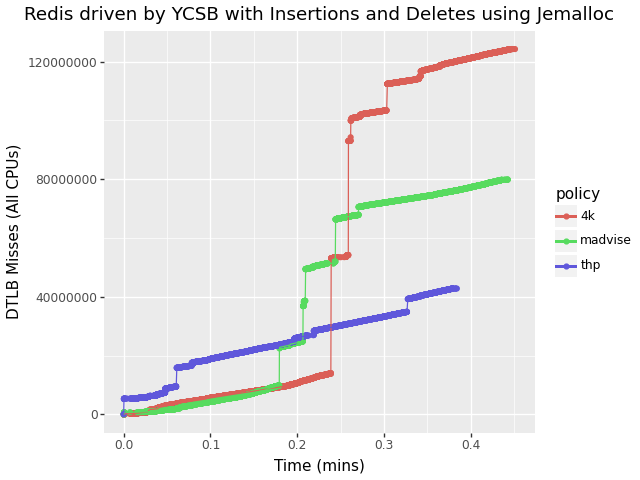

In [107]:
Image(filename="./deletes-redis-dtlb.png")

In [187]:
!pip install scikit-learn tensorflow torch

In [265]:
collect = Collector("./config/gap_never.yaml")
collect.start_collection(None)
gap_never_info = collect.wait()
collect = Collector("./config/gap_always.yaml")
collect.start_collection(None)
gap_always_info = collect.wait()


In [278]:
from IPython.display import Image, display
plt = create_rss_graph([("4k", gap_never_info),
                    ("thp", gap_always_info)],
                   "pr", 0, 
                   "pr", 0,
                   "Redis driven by YCSB with Insertions and Deletes using Jemalloc")
plt.save("deletes-gap.png")

/home/anish/.local/share/virtualenvs/KernMLOps-qEOPCQS_/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/anish/.local/share/virtualenvs/KernMLOps-qEOPCQS_/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: deletes-gap.png


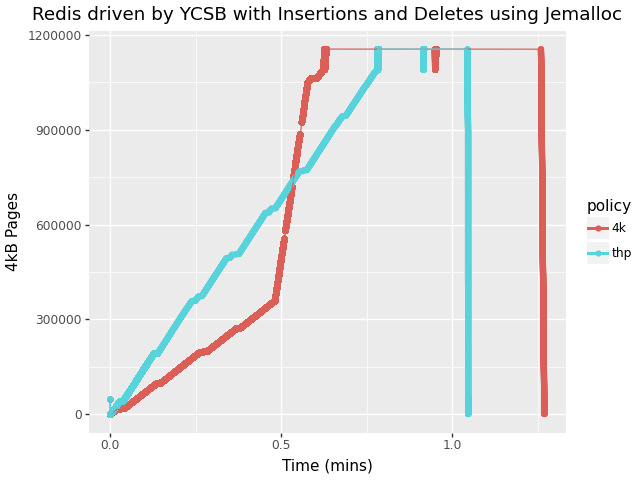

In [279]:
Image(filename="./deletes-gap.png")

In [266]:
import polars as pl

# Suppose these functions already exist (or you adapt similar ones)
def load_memory_data(filedict: dict[str, str], proc_tag: str, proc_ind: int, 
                     time_proc_tag: str, time_proc_index: int, tag: str) -> pl.DataFrame:
    """Return a dataframe with normalized time and memory usage (4k pages count)."""
    df = get_proper_rss(filedict["process_trace"],
                        filedict["mm_rss_stat"],
                        proc_tag, proc_ind,
                        time_proc_tag, time_proc_index,
                        tag)
    # Convert norm_ts_ns to minutes if not already done
    df = df.with_columns((pl.col("norm_ts_ns") / (10**9) / 60).alias("norm_time"))
    return df.select(["norm_time", "count"]).rename({"count": "memory"})

def load_dtlb_data(filedict: dict[str, str], proc_tag: str, proc_ind: int, 
                   time_proc_tag: str, time_proc_index: int, tag: str) -> pl.DataFrame:
    """Return a dataframe with normalized time and cumulative dtlb misses."""
    df = get_proper_dtlb(filedict["process_trace"],
                         filedict["dtlb_misses"],
                         proc_tag, proc_ind,
                         time_proc_tag, time_proc_index,
                         tag)
    # Convert norm_ts_ns to minutes if not already done
    df = df.with_columns((pl.col("norm_ts_ns") / (10**9) / 60).alias("norm_time"))
    return df.select(["norm_time", "cumulative_dtlb_misses"]).rename({"cumulative_dtlb_misses": "dtlb"})

In [267]:
print("Preparing Redis data...")
redis_data = {
    'never_memory': load_memory_data(redis_never_info, "redis-server", 0, "redis-server", 0, "never"),
    'never_dtlb': load_dtlb_data(redis_never_info, "redis-server", 0, "redis-server", 0, "never"),
    'always_memory': load_memory_data(redis_always_info, "redis-server", 0, "redis-server", 0, "always"),
    'always_dtlb': load_dtlb_data(redis_always_info, "redis-server", 0, "redis-server", 0, "always")
}

print("Preparing Gap data...")
gap_data = {
    'never_memory': load_memory_data(gap_never_info, "pr", 0, "pr", 0, "never"),
    'never_dtlb': load_dtlb_data(gap_never_info, "pr", 0, "pr", 0, "never"),
    'always_memory': load_memory_data(gap_always_info, "pr", 0, "pr", 0, "always"),
    'always_dtlb': load_dtlb_data(gap_always_info, "pr", 0, "pr", 0, "always")
}

# PART 2: Prepare datasets for alignment
redis_datasets = [
    ('redis_never', normalize_time(redis_data['never_memory'])),
    ('redis_never', normalize_time(redis_data['never_dtlb'])),
    ('redis_always', normalize_time(redis_data['always_memory'])),
    ('redis_always', normalize_time(redis_data['always_dtlb']))
]

gap_datasets = [
    ('gap_never', normalize_time(gap_data['never_memory'])),
    ('gap_never', normalize_time(gap_data['never_dtlb'])),
    ('gap_always', normalize_time(gap_data['always_memory'])),
    ('gap_always', normalize_time(gap_data['always_dtlb']))
]

# PART 3: Align datasets to common time grids
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np

def align_datasets_on_time_grid(datasets, desired_points=1000):
    """Aligns multiple time series datasets to a common time grid."""
    # Find min and max time across all datasets
    min_time = float('inf')
    max_time = float('-inf')
    
    for name, df in datasets:
        min_time = min(min_time, df["norm_time"].min())
        max_time = max(max_time, df["norm_time"].max())
    
    # Calculate step size
    step_size = (max_time - min_time) / desired_points
    
    # Create time grid
    time_points = np.arange(min_time, max_time + step_size, step_size)
    result_df = pd.DataFrame({"norm_time": time_points})
    
    # Interpolate each dataset to the common grid
    for name, df in datasets:
        df_pd = df.to_pandas()
        
        # Create interpolation function for each column except norm_time
        for col in df_pd.columns:
            if col != "norm_time":
                if len(df_pd) > 1:  # Need at least 2 points for interpolation
                    interp_func = interp1d(
                        df_pd["norm_time"].values,
                        df_pd[col].values,
                        bounds_error=False,
                        fill_value="extrapolate"
                    )
                    
                    # Apply interpolation
                    column_name = f"{name}_{col}"
                    result_df[column_name] = interp_func(time_points)
    
    # Handle potential NaN values
    result_df = result_df.fillna(method='ffill').fillna(method='bfill')
    return result_df

# Align each dataset to its own time grid
print("Aligning Redis datasets...")
redis_aligned = align_datasets_on_time_grid(redis_datasets)
print(f"Redis aligned shape: {redis_aligned.shape}")

print("Aligning Gap datasets...")
gap_aligned = align_datasets_on_time_grid(gap_datasets)
print(f"Gap aligned shape: {gap_aligned.shape}")

# PART 4: Scale the data
def scale_data(df, columns_to_scale):
    """Scale specified columns in DataFrame to [0,1] range."""
    scaling_params = {}
    
    for col in columns_to_scale:
        if col in df.columns:
            min_val = df[col].min()
            max_val = df[col].max()
            range_val = max_val - min_val
            
            if range_val > 0:  # Avoid division by zero
                df[f"{col}_scaled"] = (df[col] - min_val) / range_val
            else:
                df[f"{col}_scaled"] = 0.5  # Handle constant values
            
            scaling_params[col] = {'min': min_val, 'max': max_val}
    
    return df, scaling_params

# Columns to scale for Redis
redis_columns_to_scale = [
    'redis_always_memory', 'redis_always_dtlb',
    'redis_never_memory', 'redis_never_dtlb'
]

# Scale Redis data
redis_scaled, redis_scaling_params = scale_data(
    redis_aligned, 
    [col for col in redis_columns_to_scale if col in redis_aligned.columns]
)

# Columns to scale for Gap
gap_columns_to_scale = [
    'gap_always_memory', 'gap_always_dtlb',
    'gap_never_memory', 'gap_never_dtlb'
]

# Scale Gap data
gap_scaled, gap_scaling_params = scale_data(
    gap_aligned, 
    [col for col in gap_columns_to_scale if col in gap_aligned.columns]
)

Preparing Redis data...
DTLB data for pid 1281501: 4925 rows
Filtering DTLB data from 263924242908 to 263951304742 μs
DTLB data time range: 263924257512 to 263951306898 μs
DTLB data shape before filtering: (4925, 4)
DTLB data shape after filtering: (4924, 4)
Sample of filtered data (first 3 rows):
shape: (3, 4)
┌─────┬─────────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid    ┆ ts_uptime_us ┆ cumulative_dtlb_misses │
│ --- ┆ ---     ┆ ---          ┆ ---                    │
│ i64 ┆ i64     ┆ i64          ┆ i64                    │
╞═════╪═════════╪══════════════╪════════════════════════╡
│ 14  ┆ 1281501 ┆ 263924242908 ┆ 18824                  │
│ 14  ┆ 1281501 ┆ 263924257512 ┆ 18824                  │
│ 14  ┆ 1281501 ┆ 263924258703 ┆ 20697                  │
└─────┴─────────┴──────────────┴────────────────────────┘
Sample of filtered data (last 3 rows):
shape: (3, 4)
┌─────┬─────────┬──────────────┬────────────────────────┐
│ cpu ┆ tgid    ┆ ts_uptime_us ┆ cumulative_dtlb_misse

/tmp/ipykernel_1229772/2003377782.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/tmp/ipykernel_1229772/2003377782.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [268]:
def create_time_series_samples(df, columns_info, window_size=10):
    """Create time series samples for LSTM model."""
    feature_cols = columns_info['feature_cols']
    label_cols = columns_info['label_cols']
    
    # Check if columns exist
    missing_cols = [col for col in feature_cols + label_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in dataframe: {missing_cols}")
    
    # Extract features and labels
    features = df[feature_cols].values
    labels = df[label_cols].values
    
    X, y, time_points = [], [], []
    for i in range(window_size, len(df)):
        # Use previous `window_size` steps as input
        X.append(features[i-window_size:i])
        # Use current step as label
        y.append(labels[i])
        # Save corresponding time point
        time_points.append(df['norm_time'].iloc[i])
    
    return np.array(X), np.array(y), np.array(time_points)


In [269]:
# Define feature and label columns for Redis
redis_columns_info = {
    'feature_cols': ['redis_always_memory_scaled', 'redis_always_dtlb_scaled'],
    'label_cols': ['redis_never_memory_scaled', 'redis_never_dtlb_scaled']
}

# Create Redis samples
window_size = 10  # Use the same window size as original
redis_X, redis_y, redis_time = create_time_series_samples(
    redis_scaled, redis_columns_info, window_size
)

# Define feature and label columns for Gap
gap_columns_info = {
    'feature_cols': ['gap_always_memory_scaled', 'gap_always_dtlb_scaled'],
    'label_cols': ['gap_never_memory_scaled', 'gap_never_dtlb_scaled']
}

# Create Gap samples
gap_X, gap_y, gap_time = create_time_series_samples(
    gap_scaled, gap_columns_info, window_size
)

print(f"Redis samples: X={redis_X.shape}, y={redis_y.shape}")
print(f"Gap samples: X={gap_X.shape}, y={gap_y.shape}")

# PART 6: Combine datasets for unified training
# We'll combine the datasets with equal representation
# First, find the minimum number of samples to use from each dataset
n_samples = min(len(redis_X), len(gap_X))

# Randomly sample from each dataset to ensure balanced training
np.random.seed(42)  # For reproducibility
redis_indices = np.random.choice(len(redis_X), n_samples, replace=False)
gap_indices = np.random.choice(len(gap_X), n_samples, replace=False)

redis_X_subset = redis_X[redis_indices]
redis_y_subset = redis_y[redis_indices]
redis_time_subset = redis_time[redis_indices]

gap_X_subset = gap_X[gap_indices]
gap_y_subset = gap_y[gap_indices]
gap_time_subset = gap_time[gap_indices]

# Now combine the datasets
combined_X = np.concatenate([redis_X_subset, gap_X_subset], axis=0)
combined_y = np.concatenate([redis_y_subset, gap_y_subset], axis=0)

# Keep track of dataset origin for evaluation
dataset_origins = np.concatenate([
    np.zeros(len(redis_X_subset)),  # 0 for Redis
    np.ones(len(gap_X_subset))      # 1 for Gap
])

print(f"Combined dataset shape: X={combined_X.shape}, y={combined_y.shape}")

Redis samples: X=(991, 10, 2), y=(991, 2)
Gap samples: X=(991, 10, 2), y=(991, 2)
Combined dataset shape: X=(1982, 10, 2), y=(1982, 2)


In [270]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Hidden layer
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        
        # Output layer
        self.fc2 = nn.Linear(32, output_size)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Take the output from the last time step
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Dense layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

In [271]:
def train_pytorch_model(X, y, batch_size=32, epochs=50, learning_rate=0.001, validation_split=0.2):
    """Train a PyTorch LSTM model."""
    # Convert numpy arrays to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_tensor, y_tensor, test_size=validation_split, shuffle=False
    )
    
    # Create PyTorch datasets and dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    input_size = X.shape[2]  # Number of features per time step
    hidden_size = 64  # Hidden size (same as original)
    output_size = y.shape[1]  # Number of outputs
    
    model = LSTMModel(input_size, hidden_size, output_size)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Print progress
        if (epoch+1) % 10 == 0:  # Print every 10 epochs
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Calculate validation MAE
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val)
        val_mae = torch.mean(torch.abs(y_pred - y_val)).item()
    
    print(f"Final Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('unified_training_history.png')
    plt.close()
    
    # Return the model and validation data
    # Original function expected to return: model, X_val, y_val
    return model, X_val, y_val

# # Train the model on combined dataset
print("Training unified model on combined dataset...")
model, X_val_tensor, y_val_tensor = train_pytorch_model(
    combined_X, combined_y, 
    batch_size=32, 
    epochs=50, 
    learning_rate=0.001
)

Training unified model on combined dataset...
Epoch [10/50], Train Loss: 0.0159, Val Loss: 0.0177
Epoch [20/50], Train Loss: 0.0124, Val Loss: 0.0161
Epoch [30/50], Train Loss: 0.0106, Val Loss: 0.0154
Epoch [40/50], Train Loss: 0.0094, Val Loss: 0.0157
Epoch [50/50], Train Loss: 0.0087, Val Loss: 0.0180
Final Validation Loss: 0.0180, Validation MAE: 0.0660


In [272]:
# Function to make predictions with the PyTorch model
def predict_with_pytorch_model(model, X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X)
        predictions = model(X_tensor).numpy()
    return predictions

# Update the evaluate_pytorch_model function to include all four lines
def evaluate_pytorch_model(model, X_val, y_val, df_train, time_val=None, memory_madvise=None):
    # Make predictions with the model
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val)
        y_pred = model(X_val_tensor).numpy()
    
    # Convert back to original scale
    memory_nev_min = df_train['memory_nev'].min()
    memory_nev_max = df_train['memory_nev'].max()
    memory_min = df_train['memory'].min()
    memory_max = df_train['memory'].max()
    
    # Get all the data in original scale
    memory_pred_original = y_pred[:, 0] * (memory_nev_max - memory_nev_min) + memory_nev_min
    memory_actual_original = y_val[:, 0] * (memory_nev_max - memory_nev_min) + memory_nev_min
    memory_always = X_val[:, -1, 0] * (memory_max - memory_min) + memory_min
    
    # Create time array if needed
    if time_val is None:
        time_val = np.linspace(0, len(y_val)/10, len(y_val))
    
    # Calculate metrics
    mae = mean_absolute_error(memory_actual_original, memory_pred_original)
    rmse = np.sqrt(mean_squared_error(memory_actual_original, memory_pred_original))
    
    # Create visualization with all four lines
    plt.figure(figsize=(12, 6))
    
    # Line 1: Actual (Never/4K)
    plt.plot(time_val, memory_actual_original, 'b-', linewidth=2, label='Never (4KB pages)')
    
    # Line 2: Predicted from LSTM
    plt.plot(time_val, memory_pred_original, 'r--', linewidth=2, label='Predicted from LSTM')
    
    # Line 3: Madvise (if available)
    if memory_madvise is not None:
        plt.plot(time_val, memory_madvise, 'g-', linewidth=2, label='Madvise')
    
    # Line 4: Always (THP)  
    plt.plot(time_val, memory_always, 'c:', linewidth=2, label='Always (THP)')
    
    plt.title(f'\nMAE: {mae:.2f}, RMSE: {rmse:.2f}', fontsize=14)
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.ylabel('Memory Usage (4KB pages)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("graph.png", dpi=300)
    plt.show()
    
    return memory_pred_original, memory_actual_original, mae, rmse

In [273]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model_on_dataset(model, X, y, dataset_name, scaling_params):
    """
    Evaluate model on a specific dataset and visualize results
    
    Args:
        model: Trained PyTorch LSTM model
        X: Input features (scaled)
        y: True labels (scaled)
        dataset_name: Name of the dataset for plot titles
        scaling_params: Dictionary with scaling parameters to convert back to original scale
    
    Returns:
        mae, rmse: Evaluation metrics
    """
    # Make predictions
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X)
        y_pred = model(X_tensor).numpy()
    
    # Extract memory and DTLB predictions
    memory_pred = y_pred[:, 0]  # First output is memory
    dtlb_pred = y_pred[:, 1]    # Second output is DTLB misses
    
    # Extract actual values
    memory_actual = y[:, 0]
    dtlb_actual = y[:, 1]
    
    # Extract THP values from input features
    memory_thp = X[:, -1, 0]  # Last time step, first feature
    dtlb_thp = X[:, -1, 1]    # Last time step, second feature
    
    # Calculate metrics for memory
    memory_mae = mean_absolute_error(memory_actual, memory_pred)
    memory_rmse = np.sqrt(mean_squared_error(memory_actual, memory_pred))
    
    # Calculate metrics for DTLB
    dtlb_mae = mean_absolute_error(dtlb_actual, dtlb_pred)
    dtlb_rmse = np.sqrt(mean_squared_error(dtlb_actual, dtlb_pred))
    
    # Unscale values for visualization
    # This depends on your scaling_params structure 
    if dataset_name.lower() == 'redis':
        # Use Redis scaling parameters
        memory_min = scaling_params['redis_never_memory']['min']
        memory_max = scaling_params['redis_never_memory']['max']
        dtlb_min = scaling_params['redis_never_dtlb']['min']
        dtlb_max = scaling_params['redis_never_dtlb']['max']
        memory_thp_min = scaling_params['redis_always_memory']['min']
        memory_thp_max = scaling_params['redis_always_memory']['max']
        dtlb_thp_min = scaling_params['redis_always_dtlb']['min'] 
        dtlb_thp_max = scaling_params['redis_always_dtlb']['max']
    else:
        # Use Gap scaling parameters
        memory_min = scaling_params['gap_never_memory']['min']
        memory_max = scaling_params['gap_never_memory']['max'] 
        dtlb_min = scaling_params['gap_never_dtlb']['min']
        dtlb_max = scaling_params['gap_never_dtlb']['max']
        memory_thp_min = scaling_params['gap_always_memory']['min']
        memory_thp_max = scaling_params['gap_always_memory']['max']
        dtlb_thp_min = scaling_params['gap_always_dtlb']['min']
        dtlb_thp_max = scaling_params['gap_always_dtlb']['max']
    
    # Unscale memory values
    memory_pred_original = memory_pred * (memory_max - memory_min) + memory_min
    memory_actual_original = memory_actual * (memory_max - memory_min) + memory_min
    memory_thp_original = memory_thp * (memory_thp_max - memory_thp_min) + memory_thp_min
    
    # Unscale DTLB values
    dtlb_pred_original = dtlb_pred * (dtlb_max - dtlb_min) + dtlb_min
    dtlb_actual_original = dtlb_actual * (dtlb_max - dtlb_min) + dtlb_min
    dtlb_thp_original = dtlb_thp * (dtlb_thp_max - dtlb_thp_min) + dtlb_thp_min
    
    # Create time array 
    time_points = np.linspace(0, len(y)/10, len(y))  # Assuming 10 samples per time unit
    
    # Create memory usage visualization
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, memory_actual_original, 'b-', linewidth=2, label='Actual 4KB pages (never)')
    plt.plot(time_points, memory_pred_original, 'r--', linewidth=2, label='Predicted from LSTM')
    plt.plot(time_points, memory_thp_original, 'g:', linewidth=2, label='Actual THP (always)')
    
    plt.title(f'{dataset_name} Memory Usage: MAE={memory_mae:.4f}, RMSE={memory_rmse:.4f}', fontsize=14)
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.ylabel('Memory Usage (4KB pages)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{dataset_name.lower()}_memory_prediction.png", dpi=300)
    plt.close()
    
    # Create DTLB misses visualization
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, dtlb_actual_original, 'b-', linewidth=2, label='Actual 4KB pages (never)')
    plt.plot(time_points, dtlb_pred_original, 'r--', linewidth=2, label='Predicted from LSTM')
    plt.plot(time_points, dtlb_thp_original, 'g:', linewidth=2, label='Actual THP (always)')
    
    plt.title(f'{dataset_name} DTLB Misses: MAE={dtlb_mae:.4f}, RMSE={dtlb_rmse:.4f}', fontsize=14)
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.ylabel('DTLB Misses', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{dataset_name.lower()}_dtlb_prediction.png", dpi=300)
    plt.close()
    
    # Return metrics for both memory and DTLB
    return {
        'memory_mae': memory_mae,
        'memory_rmse': memory_rmse,
        'dtlb_mae': dtlb_mae,
        'dtlb_rmse': dtlb_rmse
    }

# Assuming these variables are available from previous code:
# - model: trained PyTorch LSTM model
# - redis_X, redis_y: Redis test data (scaled)
# - gap_X, gap_y: Gap test data (scaled)
# - redis_scaling_params, gap_scaling_params: Scaling parameters for both datasets

def main():
    # Example usage (this would be replaced with your actual variables)
    # Load your trained model
    # model = torch.load("your_saved_model.pth")
    
    # Get Redis test data (use validation split from original data)
    redis_test_X = redis_X[redis_indices[-int(len(redis_indices)*0.2):]]
    redis_test_y = redis_y[redis_indices[-int(len(redis_indices)*0.2):]]
    
    # Get Gap test data (use validation split from original data)
    gap_test_X = gap_X[gap_indices[-int(len(gap_indices)*0.2):]]
    gap_test_y = gap_y[gap_indices[-int(len(gap_indices)*0.2):]]
    
    # Combine scaling parameters
    scaling_params = {**redis_scaling_params, **gap_scaling_params}
    
    # Evaluate on Redis
    print("Evaluating model on Redis dataset...")
    redis_metrics = evaluate_model_on_dataset(model, redis_test_X, redis_test_y, "Redis", scaling_params)
    
    # Evaluate on Gap
    print("Evaluating model on Gap dataset...")
    gap_metrics = evaluate_model_on_dataset(model, gap_test_X, gap_test_y, "Gap", scaling_params)
    
    # Print comparison of metrics
    print("\nModel Performance Comparison:")
    print("-" * 50)
    print(f"{'Metric':<15} {'Redis':>15} {'Gap':>15}")
    print("-" * 50)
    print(f"{'Memory MAE':<15} {redis_metrics['memory_mae']:>15.4f} {gap_metrics['memory_mae']:>15.4f}")
    print(f"{'Memory RMSE':<15} {redis_metrics['memory_rmse']:>15.4f} {gap_metrics['memory_rmse']:>15.4f}")
    print(f"{'DTLB MAE':<15} {redis_metrics['dtlb_mae']:>15.4f} {gap_metrics['dtlb_mae']:>15.4f}")
    print(f"{'DTLB RMSE':<15} {redis_metrics['dtlb_rmse']:>15.4f} {gap_metrics['dtlb_rmse']:>15.4f}")
    print("-" * 50)
    
    return redis_metrics, gap_metrics

if __name__ == "__main__":
    redis_metrics, gap_metrics = main()

Evaluating model on Redis dataset...
Evaluating model on Gap dataset...

Model Performance Comparison:
--------------------------------------------------
Metric                    Redis             Gap
--------------------------------------------------
Memory MAE               0.0348          0.0492
Memory RMSE              0.0393          0.0985
DTLB MAE                 0.0343          0.0905
DTLB RMSE                0.0498          0.1722
--------------------------------------------------


Epoch [10/50], Train Loss: 0.0157, Val Loss: 0.0011
Epoch [20/50], Train Loss: 0.0079, Val Loss: 0.0007
Epoch [30/50], Train Loss: 0.0050, Val Loss: 0.0004
Epoch [40/50], Train Loss: 0.0043, Val Loss: 0.0004
Epoch [50/50], Train Loss: 0.0038, Val Loss: 0.0003
Final Validation Loss: 0.0003, Validation MAE: 0.0147


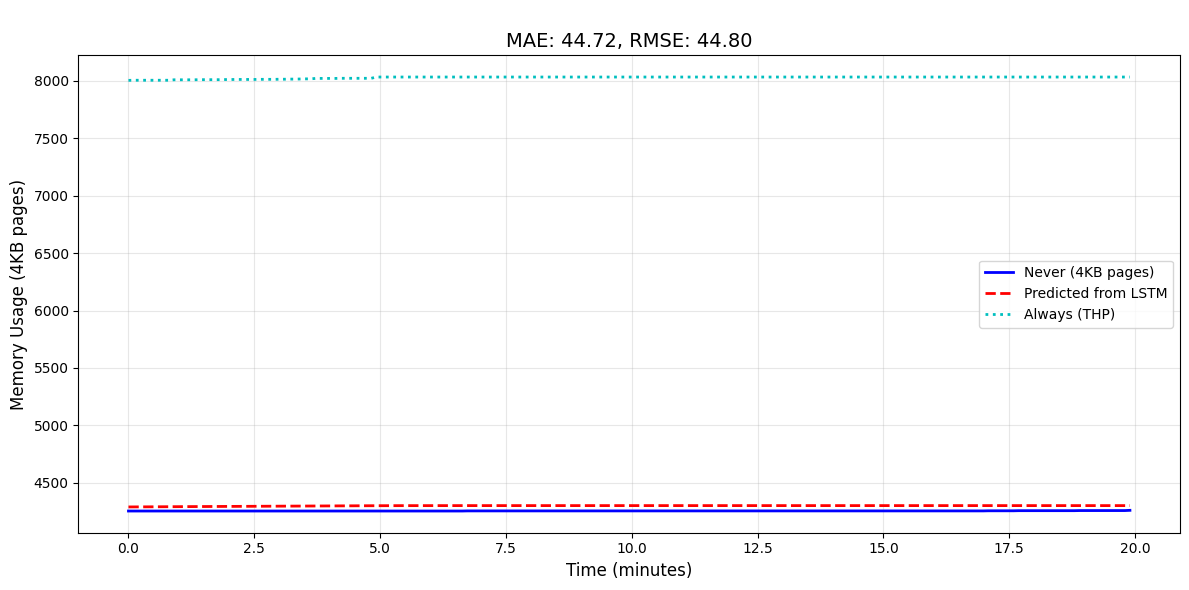

In [274]:
# Train the PyTorch model
pytorch_model, X_val_tensor, y_val_tensor = train_pytorch_model(X, y, batch_size=32, epochs=50)

# Evaluate the model
memory_pred, memory_actual, mae, rmse = evaluate_pytorch_model(
    pytorch_model, 
    X_val_tensor.numpy(), 
    y_val_tensor.numpy(), 
    df_train
)

Evaluating model on separate benchmarks...

Evaluating on Redis benchmark:

Evaluating on Gap benchmark:

Cross-benchmark Performance Comparison:
--------------------------------------------------
Metric                    Redis             Gap
--------------------------------------------------
Memory MAE               0.0346          0.0434
Memory RMSE              0.0377          0.0814
DTLB MAE                 0.0342          0.0686
DTLB RMSE                0.0506          0.1336
--------------------------------------------------

Cross-application performance analysis:
- Model predicts Redis memory usage more accurately than Gap
- Model predicts Redis DTLB misses more accurately than Gap

Redis Memory Usage Prediction:


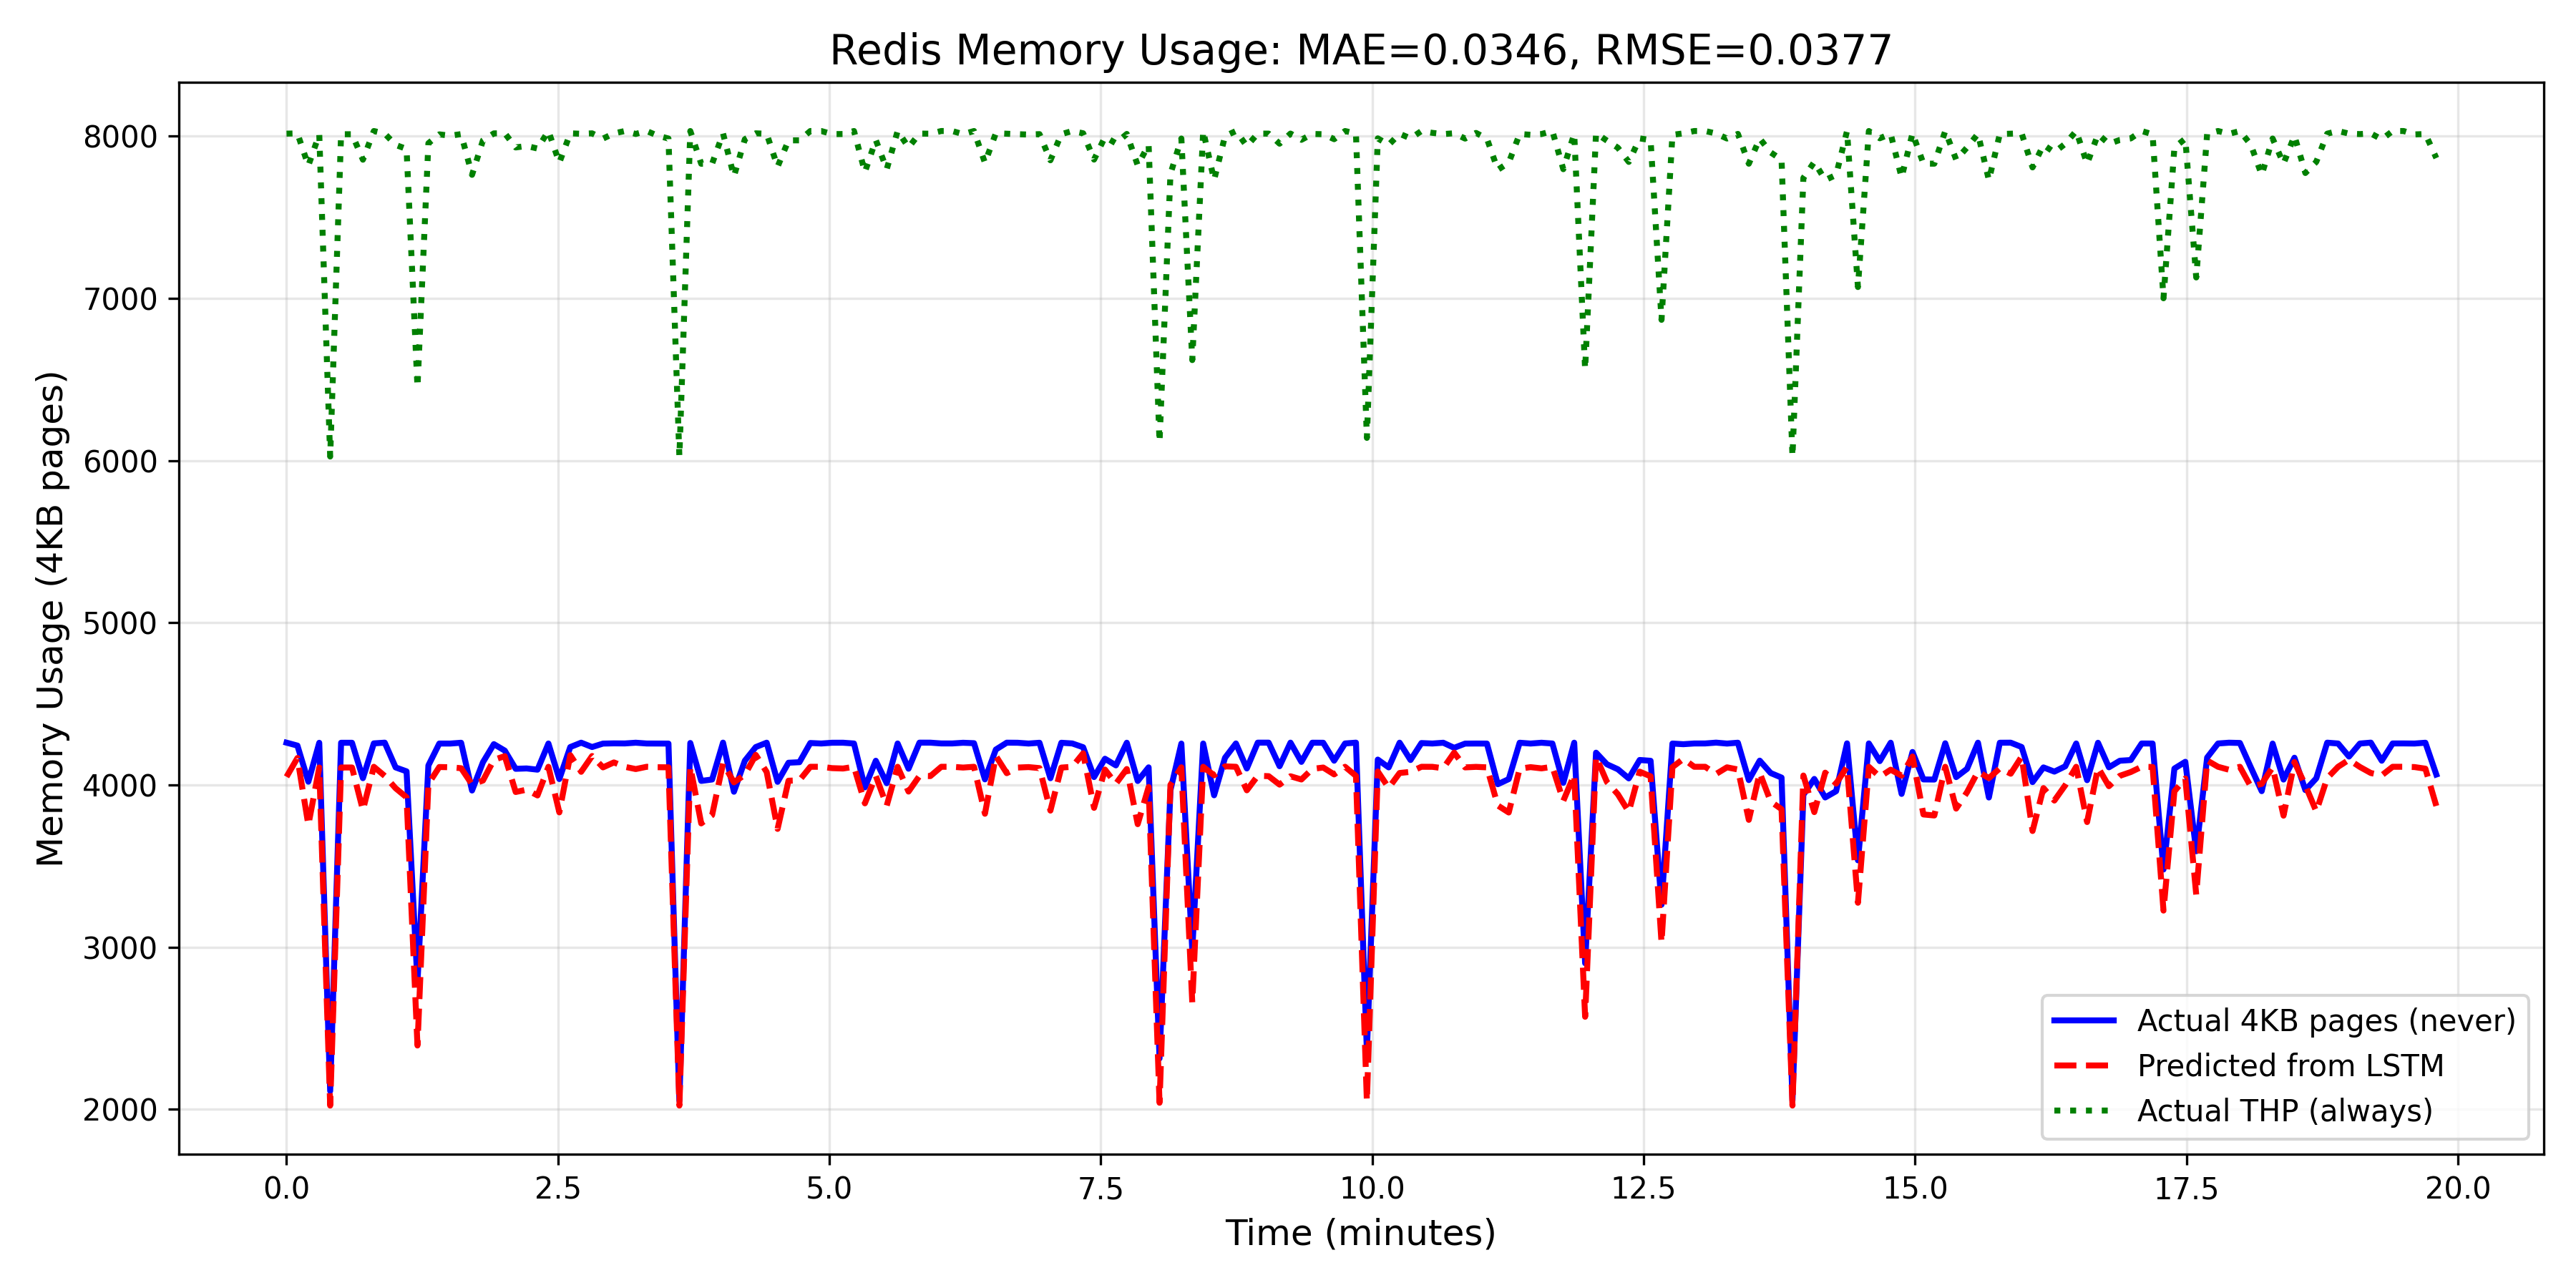


Gap Memory Usage Prediction:


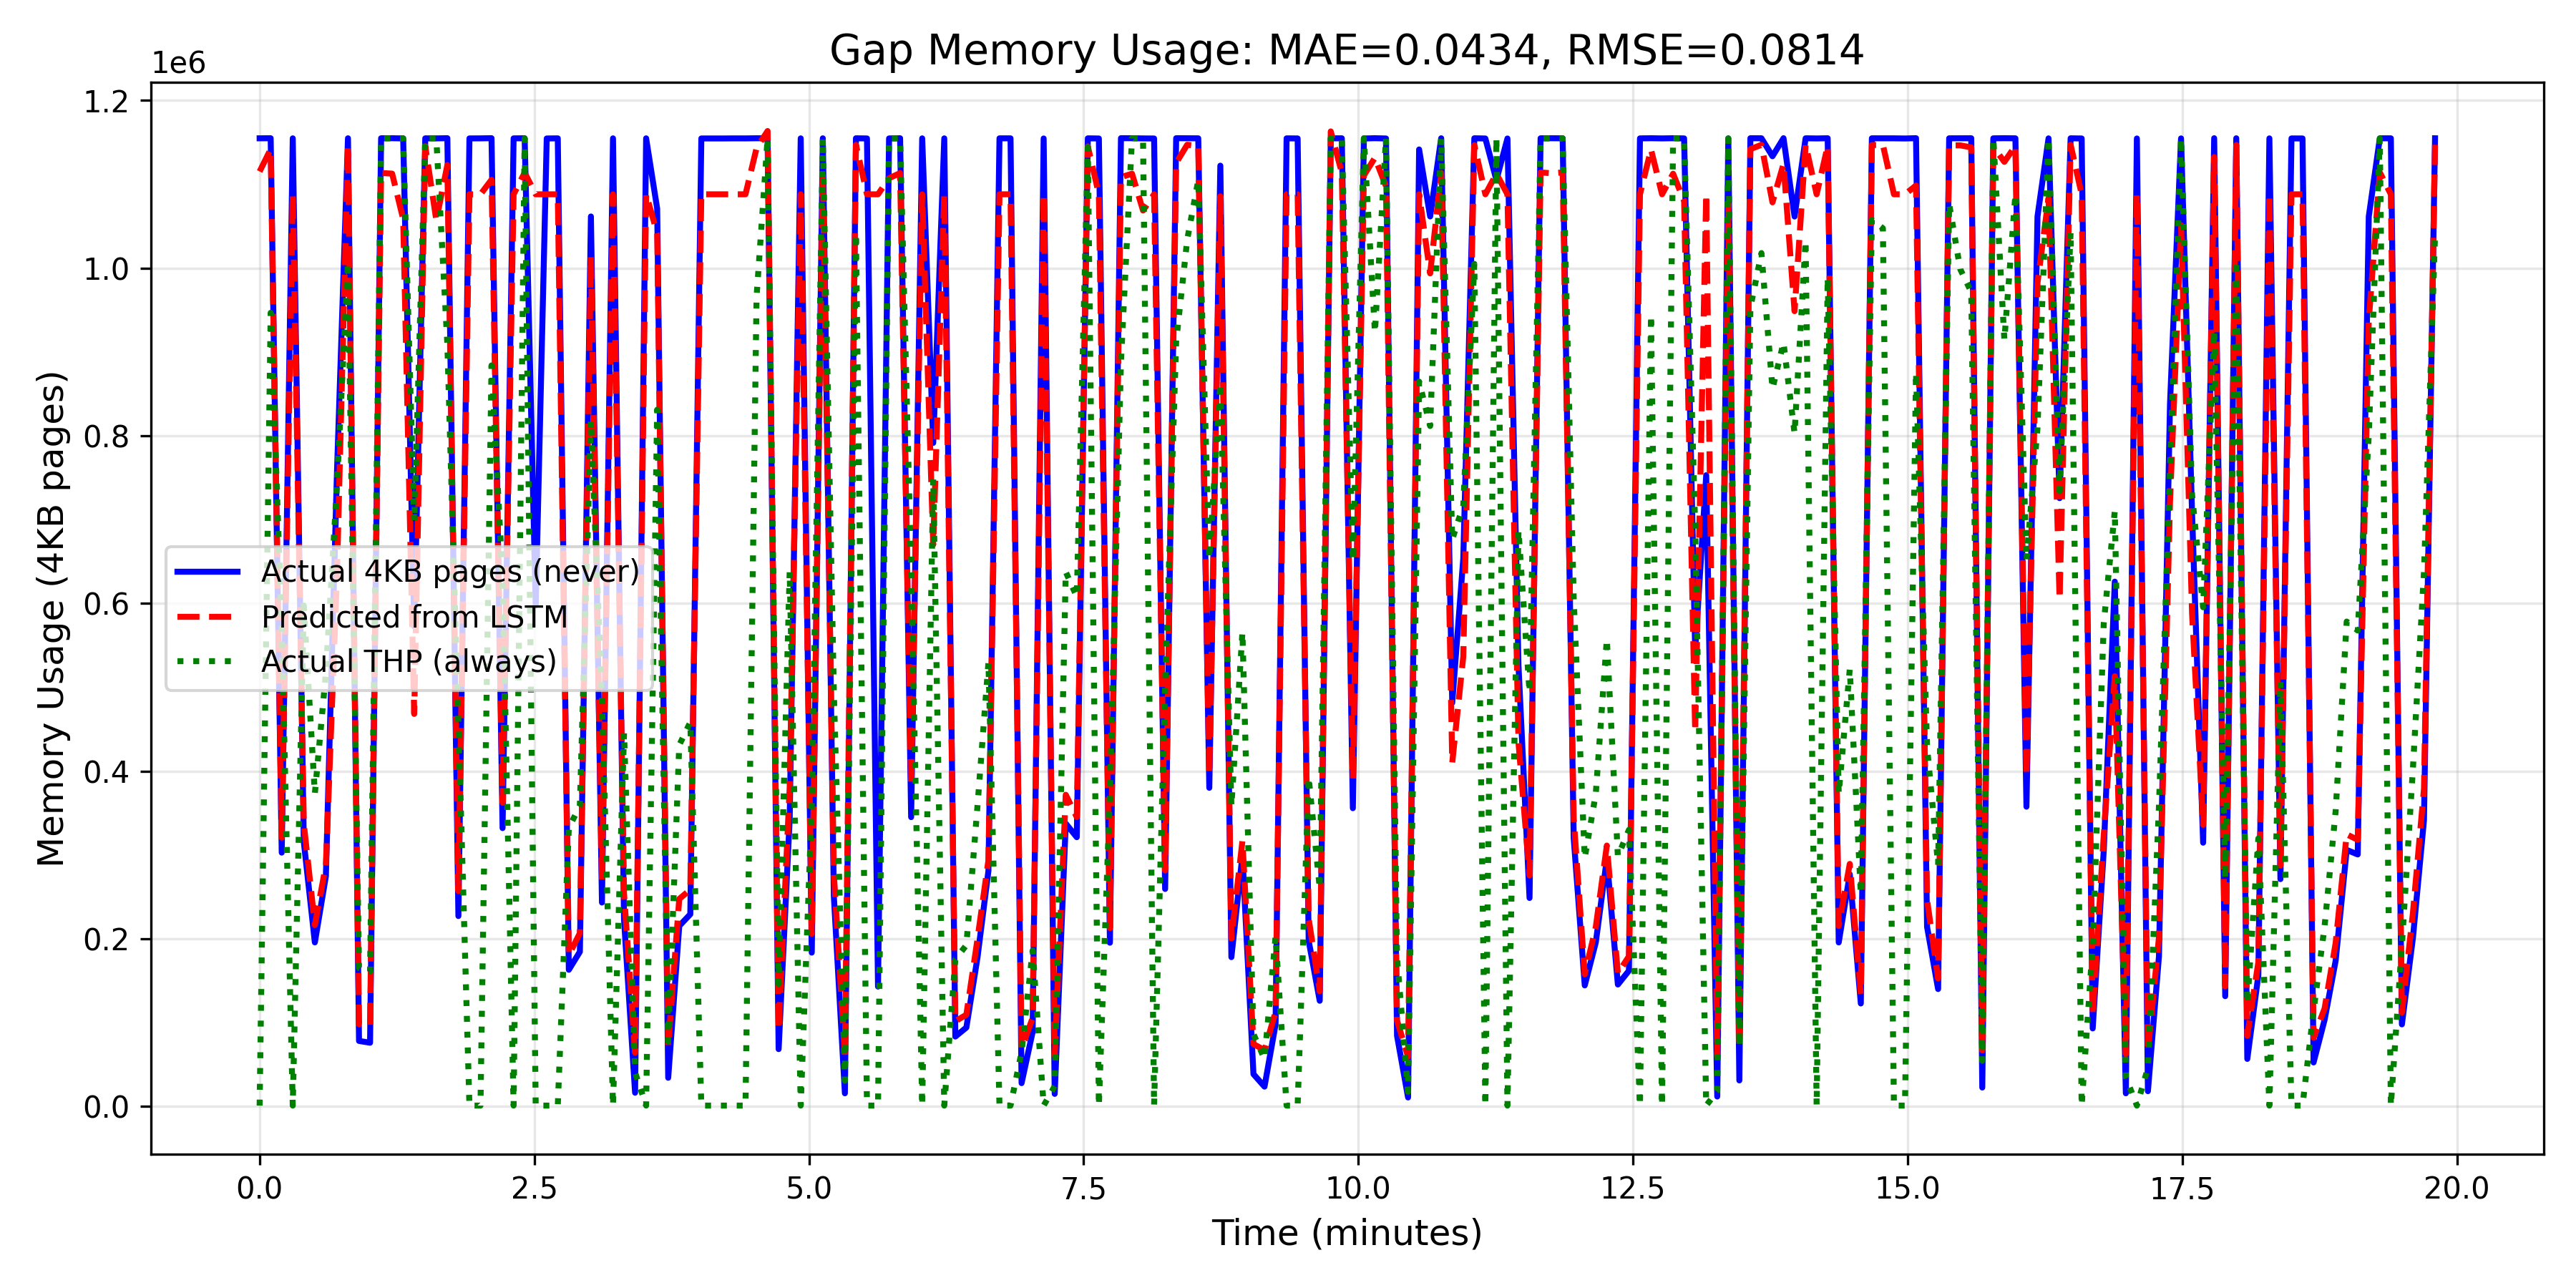

In [275]:
# Add this code after your model training section

# Extract test data for separate evaluation
# For Redis
redis_test_indices = np.random.choice(len(redis_X), int(len(redis_X)*0.2), replace=False)
redis_test_X = redis_X[redis_test_indices]
redis_test_y = redis_y[redis_test_indices]

# For Gap
gap_test_indices = np.random.choice(len(gap_X), int(len(gap_X)*0.2), replace=False)
gap_test_X = gap_X[gap_test_indices]
gap_test_y = gap_y[gap_test_indices]

# Combine scaling parameters from both datasets
all_scaling_params = {}
all_scaling_params.update(redis_scaling_params)
all_scaling_params.update(gap_scaling_params)

print("Evaluating model on separate benchmarks...")


# Evaluate on Redis dataset
print("\nEvaluating on Redis benchmark:")
redis_metrics = evaluate_model_on_dataset(model, redis_test_X, redis_test_y, "Redis", all_scaling_params)

# Evaluate on Gap dataset
print("\nEvaluating on Gap benchmark:")
gap_metrics = evaluate_model_on_dataset(model, gap_test_X, gap_test_y, "Gap", all_scaling_params)

# Print comparison table
print("\nCross-benchmark Performance Comparison:")
print("-" * 50)
print(f"{'Metric':<15} {'Redis':>15} {'Gap':>15}")
print("-" * 50)
print(f"{'Memory MAE':<15} {redis_metrics['memory_mae']:>15.4f} {gap_metrics['memory_mae']:>15.4f}")
print(f"{'Memory RMSE':<15} {redis_metrics['memory_rmse']:>15.4f} {gap_metrics['memory_rmse']:>15.4f}")
print(f"{'DTLB MAE':<15} {redis_metrics['dtlb_mae']:>15.4f} {gap_metrics['dtlb_mae']:>15.4f}")
print(f"{'DTLB RMSE':<15} {redis_metrics['dtlb_rmse']:>15.4f} {gap_metrics['dtlb_rmse']:>15.4f}")
print("-" * 50)

# Analyze cross-application performance
print("\nCross-application performance analysis:")
if redis_metrics['memory_mae'] < gap_metrics['memory_mae']:
    print("- Model predicts Redis memory usage more accurately than Gap")
else:
    print("- Model predicts Gap memory usage more accurately than Redis")

if redis_metrics['dtlb_mae'] < gap_metrics['dtlb_mae']:
    print("- Model predicts Redis DTLB misses more accurately than Gap")
else:
    print("- Model predicts Gap DTLB misses more accurately than Redis")

# You can also display the generated visualizations in a notebook environment
from IPython.display import Image, display

print("\nRedis Memory Usage Prediction:")
display(Image(filename="redis_memory_prediction.png"))

print("\nGap Memory Usage Prediction:")
display(Image(filename="gap_memory_prediction.png"))



In [285]:
from typing import Mapping
def train(df: list[Mapping[str, list[Path]]]) -> (torch.nn.Module, float):
    """
    Train an LSTM model to predict memory and DTLB usage from workload data
    
    Args:
        df: A list of mappings from string identifiers to lists of Path objects
           Each mapping should contain paths to process_trace, mm_rss_stat, and dtlb_misses files
    
    Returns:
        model: Trained PyTorch LSTM model
        accuracy: Float value representing model accuracy after cross-validation
    """
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader
    import polars as pl
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error
    import pandas as pd
    from scipy.interpolate import interp1d
    
    # Define the LSTM model class
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
            super(LSTMModel, self).__init__()
            self.hidden_size = hidden_size
            
            # LSTM layer
            self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
            
            # Dropout layer
            self.dropout = nn.Dropout(dropout_rate)
            
            # Hidden layer
            self.fc1 = nn.Linear(hidden_size, 32)
            self.relu = nn.ReLU()
            
            # Output layer
            self.fc2 = nn.Linear(32, output_size)
        
        def forward(self, x):
            # Initialize hidden state with zeros
            h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
            
            # Forward propagate LSTM
            out, _ = self.lstm(x, (h0, c0))  # shape: (batch_size, seq_length, hidden_size)
            
            # Take output from last time step
            out = out[:, -1, :]
            
            # Apply dropout
            out = self.dropout(out)
            
            # Dense layers
            out = self.fc1(out)
            out = self.relu(out)
            out = self.fc2(out)
            
            return out
    
    # Helper functions from the script 
    def filter_process_trace(process_trace_df: pl.DataFrame) -> pl.DataFrame:
        df = process_trace_df
        # Filter just the processes
        df = df.filter(pl.col("tgid") == pl.col("pid")).drop("collection_id")

        # Find the last name of each process
        start_df = df.sort(pl.col("ts_ns"), descending=True)
        helper_dict = {}
        for row in start_df.iter_rows():
            pid = row[0]
            comm = row[3]
            if pid in helper_dict.keys() or comm == "": 
                continue
            helper_dict[pid] = comm

        # Separate the start and end
        full_df = start_df.with_columns(pl.col("pid").map_elements(lambda x: helper_dict.get(x, ""), return_dtype=str).alias("full_name"))
        full_df = full_df.drop(["tgid", "name"])
        start_df = full_df.filter(pl.col("cap_type") == "start").rename({"ts_ns": "start_ns"}).drop("cap_type")
        end_df = full_df.filter(pl.col("cap_type") == "end").rename({"ts_ns": "end_ns"}).drop(["cap_type", "full_name"])

        # Join them to get the process table
        combined_df = start_df.join(end_df, "pid")
        return combined_df.with_columns((pl.col("end_ns") - pl.col("start_ns")).alias("duration"))

    def process_trace_start_end_ts(process_trace_df: pl.DataFrame, proc_name: str, index: int) -> (int, int, int):
        trace_df = filter_process_trace(process_trace_df).sort(pl.col("start_ns"))
        df = trace_df.filter(pl.col("full_name") == proc_name)
        
        if index >= len(df):
            raise ValueError(f"Index {index} out of range for process {proc_name}")
        
        # Instead of using row() which might have unexpected behavior,
        # let's get the values directly from the dataframe:
        pid = df["pid"][index]
        start_ns = df["start_ns"][index]
        end_ns = df["end_ns"][index]
        
        return pid, start_ns, end_ns

    def clean_rss_pid(rss_df: pl.DataFrame, pid: int) -> pl.DataFrame:
        df = rss_df.drop(["pid", "collection_id"]).sort(pl.col("ts_ns"))
        df = df.filter(pl.col("tgid") == pid)
        df = df.with_columns(pl.when(pl.col("member") == "MM_FILEPAGES")
                         .then(pl.col("count"))
                         .otherwise(None)
                         .fill_null(strategy="forward")
                         .fill_null(strategy="backward")
                         .alias("file"))
        df = df.with_columns(pl.when(pl.col("member") == "MM_ANONPAGES")
                         .then(pl.col("count"))
                         .otherwise(None)
                         .fill_null(strategy="forward")
                         .fill_null(strategy="backward")
                         .alias("anon"))
        df = df.with_columns(pl.when(pl.col("member") == "MM_SWAPENTS")
                         .then(pl.col("count"))
                         .otherwise(None)
                         .fill_null(strategy="forward")
                         .fill_null(strategy="backward")
                         .alias("swap"))
        df = df.drop(["member", "count"])
        zero_df = pl.DataFrame({"tgid": pid, "ts_ns": -1, "file": 0, "anon": 0, "swap": 0})
        df = pl.concat([df, zero_df]).sort("ts_ns")
        df = df.fill_null(strategy="forward")
        df = df.filter(pl.col("ts_ns") >= 0)
        df = df.with_columns((pl.col("file") + pl.col("anon") + pl.col("swap")).alias("count"))
        df = df.drop(["file", "anon", "swap"])
        return df
        
    def filter_rss_with_ts(rss_trace_df: pl.DataFrame, start: int, end: int):
        new_frame_dict = {}
        for column_name in rss_trace_df.columns:
            new_frame_dict[column_name] = [None, None]
        new_frame_dict["ts_ns"] = [start, end]
        df = rss_trace_df.vstack(pl.DataFrame(new_frame_dict))
        df = df.sort(pl.col("ts_ns")).fill_null(strategy="forward").fill_null(strategy="backward")
        return df.filter(pl.col("ts_ns").is_between(start, end, closed='both'))

    def clean_dtlb_pid(dtlb_df: pl.DataFrame, pid: int) -> pl.DataFrame:
        # Drop unnecessary columns, but keep the ones we need
        df = dtlb_df.drop(["pid", "pmu_enabled_time_us", 
                         "pmu_running_time_us", "collection_id"])
        
        # Filter to only include rows for the specified process
        df = df.filter(pl.col("tgid") == pid)
        
        # Keep all CPUs, sort by timestamp and CPU
        df = df.sort(["ts_uptime_us", "cpu"])
        
        return df

    def filter_dtlb_with_ts(dtlb_trace_df: pl.DataFrame, start: int, end: int):
        start_us = start // 1000  # Convert ns to us
        end_us = end // 1000      # Convert ns to us
        
        new_frame_dict = {}
        for column_name in dtlb_trace_df.columns:
            new_frame_dict[column_name] = [None, None]
        new_frame_dict["ts_uptime_us"] = [start_us, end_us]
        
        df = dtlb_trace_df.vstack(pl.DataFrame(new_frame_dict))
        df = df.sort(pl.col("ts_uptime_us")).fill_null(strategy="forward").fill_null(strategy="backward")
        
        return df.filter(pl.col("ts_uptime_us").is_between(start_us, end_us, closed='both'))
    
    def get_workload_data_for_task(filedict, proc_name, proc_ind, task_name, task_ind, tag):
        """Extract memory and DTLB data for a specific workload"""
        proc_trace_df = pl.read_parquet(filedict["process_trace"][0])
        
        # Get memory data
        rss_df = pl.read_parquet(filedict["mm_rss_stat"][0])
        _, start, end = process_trace_start_end_ts(proc_trace_df, task_name, task_ind)
        pid, _, _ = process_trace_start_end_ts(proc_trace_df, proc_name, proc_ind)
        
        memory_df = filter_rss_with_ts(clean_rss_pid(rss_df, pid), start, end)
        memory_df = memory_df.with_columns((pl.col("ts_ns") - pl.min("ts_ns")).alias("norm_ts_ns"))
        
        # Get DTLB data
        dtlb_df = pl.read_parquet(filedict["dtlb_misses"][0])
        dtlb_clean_df = clean_dtlb_pid(dtlb_df, pid)
        dtlb_filtered_df = filter_dtlb_with_ts(dtlb_clean_df, start, end)
        
        # Aggregate DTLB misses across CPUs
        if dtlb_filtered_df.shape[0] > 0:
            # Get unique timestamps and CPUs
            unique_ts = dtlb_filtered_df.select("ts_uptime_us").unique().sort("ts_uptime_us")
            unique_cpus = dtlb_filtered_df.select("cpu").unique().sort("cpu")
            
            # Process each CPU
            cpu_dfs = []
            for cpu in unique_cpus["cpu"]:
                cpu_df = dtlb_filtered_df.filter(pl.col("cpu") == cpu).select(["ts_uptime_us", "cumulative_dtlb_misses"])
                
                # Create DataFrame with all timestamps for this CPU
                full_ts_df = unique_ts.join(cpu_df, on="ts_uptime_us", how="left")
                
                # Fill nulls and ensure monotonic increase
                full_ts_df = full_ts_df.with_columns(
                    pl.col("cumulative_dtlb_misses")
                    .fill_null(strategy="forward")
                    .fill_null(0)
                    .cum_max()
                    .alias("cumulative_dtlb_misses")
                ).with_columns(
                    pl.lit(cpu).alias("cpu")
                )
                
                cpu_dfs.append(full_ts_df)
            
            # Combine all CPU DataFrames
            combined_df = pl.concat(cpu_dfs)
            
            # Sum DTLB misses across CPUs
            dtlb_df = combined_df.group_by("ts_uptime_us").agg(
                cumulative_dtlb_misses=pl.col("cumulative_dtlb_misses").sum()
            ).sort("ts_uptime_us")
            
            # Ensure strictly increasing misses
            dtlb_df = dtlb_df.with_columns(
                pl.col("cumulative_dtlb_misses").cum_max().alias("cumulative_dtlb_misses")
            )
            
            # Convert to ns for alignment with memory data
            min_ts_us = dtlb_df["ts_uptime_us"].min()
            dtlb_df = dtlb_df.with_columns(
                ((pl.col("ts_uptime_us") - min_ts_us) * 1000).alias("norm_ts_ns")
            )
        else:
            # Create empty dataframe with correct schema
            dtlb_df = pl.DataFrame({
                "ts_uptime_us": [],
                "cumulative_dtlb_misses": [],
                "norm_ts_ns": []
            })
        
        return memory_df, dtlb_df
    
    def align_datasets(memory_df, dtlb_df, desired_points=1000):
        """Align memory and DTLB datasets to a common time grid"""
        # Convert to pandas for interpolation
        memory_pd = memory_df.select(["norm_ts_ns", "count"]).to_pandas()
        dtlb_pd = dtlb_df.select(["norm_ts_ns", "cumulative_dtlb_misses"]).to_pandas()
        
        # Find min and max time across both datasets
        min_time = min(memory_pd["norm_ts_ns"].min(), dtlb_pd["norm_ts_ns"].min() if len(dtlb_pd) > 0 else float('inf'))
        max_time = max(memory_pd["norm_ts_ns"].max(), dtlb_pd["norm_ts_ns"].max() if len(dtlb_pd) > 0 else float('-inf'))
        
        if min_time == float('inf'):
            min_time = memory_pd["norm_ts_ns"].min()
        if max_time == float('-inf'):
            max_time = memory_pd["norm_ts_ns"].max()
        
        # Create time grid
        step_size = (max_time - min_time) / desired_points
        time_points = np.arange(min_time, max_time + step_size, step_size)
        
        # Create result dataframe
        result_df = pd.DataFrame({"norm_ts_ns": time_points})
        
        # Interpolate memory data
        if len(memory_pd) > 1:
            memory_interp = interp1d(
                memory_pd["norm_ts_ns"].values,
                memory_pd["count"].values,
                bounds_error=False,
                fill_value="extrapolate"
            )
            result_df["memory"] = memory_interp(time_points)
        else:
            result_df["memory"] = 0
        
        # Interpolate DTLB data if available
        if len(dtlb_pd) > 1:
            dtlb_interp = interp1d(
                dtlb_pd["norm_ts_ns"].values,
                dtlb_pd["cumulative_dtlb_misses"].values,
                bounds_error=False,
                fill_value="extrapolate"
            )
            result_df["dtlb"] = dtlb_interp(time_points)
        else:
            result_df["dtlb"] = 0
        
        # Handle NaN values
        result_df = result_df.fillna(method='ffill').fillna(method='bfill')
        return result_df
    
    def create_time_series_samples(df, window_size=10):
        """Create time series samples for LSTM model"""
        # Extract features
        features = df[["memory", "dtlb"]].values
        
        X, y = [], []
        for i in range(window_size, len(df)):
            # Use previous window_size steps as input
            X.append(features[i-window_size:i])
            # Use current step as label
            y.append(features[i])
        
        return np.array(X), np.array(y)
    
    def scale_data(data):
        """Scale data to [0,1] range"""
        min_vals = np.min(data, axis=0)
        max_vals = np.max(data, axis=0)
        range_vals = max_vals - min_vals
        
        # Handle zero ranges
        range_vals[range_vals == 0] = 1
        
        scaled_data = (data - min_vals) / range_vals
        
        return scaled_data, min_vals, max_vals
    
    # STEP 1: Process input data
    workloads_data = []
    
    for workload_dict in df:
        # Get process names and task names from file structure
        if "process_trace" not in workload_dict or "mm_rss_stat" not in workload_dict or "dtlb_misses" not in workload_dict:
            raise ValueError("Each workload dictionary must contain process_trace, mm_rss_stat, and dtlb_misses keys")
        
        proc_trace_df = pl.read_parquet(workload_dict["process_trace"][0])
        
        # Extract processes
        processes = filter_process_trace(proc_trace_df)
        unique_processes = processes["full_name"].unique().to_list()
        
        # For each workload, we'll need to determine the main process and task
        # For simplicity, we'll use the first process that's not a system process
        main_process = None
        for proc in unique_processes:
            if proc and not proc.startswith("system") and proc != "bash" and proc != "make":
                main_process = proc
                break
        
        if not main_process:
            # If no suitable process found, use the longest running process
            processes = processes.sort(pl.col("duration"), descending=True)
            main_process = processes["full_name"][0]
        
        # Get data for this workload
        memory_df, dtlb_df = get_workload_data_for_task(
            workload_dict, 
            main_process, 0,  # Assume first instance of the process
            main_process, 0,  # Use same process for timing
            "workload"
        )
        
        # Align datasets
        aligned_df = align_datasets(memory_df, dtlb_df)
        
        # Add to workload data
        workloads_data.append(aligned_df)
    
    # STEP 2: Prepare dataset for model
    all_X = []
    all_y = []
    
    window_size = 10  # Same as in the script
    
    for workload_df in workloads_data:
        # Create time series samples
        X, y = create_time_series_samples(workload_df, window_size)
        
        # Scale the data
        X_reshaped = X.reshape(-1, X.shape[-1])
        X_scaled, X_min, X_max = scale_data(X_reshaped)
        X_scaled = X_scaled.reshape(X.shape)
        
        y_scaled, _, _ = scale_data(y)
        
        all_X.append(X_scaled)
        all_y.append(y_scaled)
    
    # Combine all workload data
    combined_X = np.vstack(all_X)
    combined_y = np.vstack(all_y)
    
    # STEP 3: Cross-validation
    n_folds = 5
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    cv_scores = []
    
    # Model parameters
    input_size = combined_X.shape[2]  # Number of features per time step
    hidden_size = 64
    output_size = combined_y.shape[1]
    
    # Training parameters
    batch_size = 32
    epochs = 50
    learning_rate = 0.001
    
    # Initialize the final model (will be trained on all data at the end)
    final_model = LSTMModel(input_size, hidden_size, output_size)
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kf.split(combined_X)):
        print(f"Training fold {fold+1}/{n_folds}")
        
        # Split data
        X_train, X_val = combined_X[train_idx], combined_X[val_idx]
        y_train, y_val = combined_y[train_idx], combined_y[val_idx]
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train)
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.FloatTensor(y_val)
        
        # Create datasets and dataloaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model for this fold
        model = LSTMModel(input_size, hidden_size, output_size)
        
        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training loop
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            
            for batch_X, batch_y in train_loader:
                # Forward pass
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * batch_X.size(0)
            
            train_loss = train_loss / len(train_loader.dataset)
            
            # Validation
            model.eval()
            val_loss = 0
            
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    val_loss += loss.item() * batch_X.size(0)
            
            val_loss = val_loss / len(val_loader.dataset)
            
            # Print progress for last epoch
            if epoch == epochs - 1:
                print(f"Fold {fold+1}, Final Loss: Train={train_loss:.4f}, Val={val_loss:.4f}")
        
        # Calculate validation MAE as accuracy metric
        model.eval()
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                all_preds.append(outputs.numpy())
                all_targets.append(batch_y.numpy())
        
        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)
        
        mae = mean_absolute_error(all_targets, all_preds)
        cv_scores.append(1.0 - mae)  # Convert MAE to accuracy (1 - error)
    
    # Calculate cross-validation accuracy
    cv_accuracy = np.mean(cv_scores)
    print(f"Cross-validation accuracy: {cv_accuracy:.4f}")
    
    # STEP 4: Train final model on all data
    # Convert all data to PyTorch tensors
    X_tensor = torch.FloatTensor(combined_X)
    y_tensor = torch.FloatTensor(combined_y)
    
    # Create dataset and dataloader
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize the final model
    final_model = LSTMModel(input_size, hidden_size, output_size)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(epochs):
        final_model.train()
        epoch_loss = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = final_model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * batch_X.size(0)
        
        epoch_loss = epoch_loss / len(dataloader.dataset)
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
    
    print(f"Final model training completed. Returning model and accuracy: {cv_accuracy:.4f}")
    
    return final_model, cv_accuracy

In [286]:
model, acc = train([redis_never_info, redis_always_info])
print(acc)

/tmp/ipykernel_1229772/2265638059.py:291: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/tmp/ipykernel_1229772/2265638059.py:291: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


Training fold 1/5
Fold 1, Final Loss: Train=0.0008, Val=0.0002
Training fold 2/5
Fold 2, Final Loss: Train=0.0009, Val=0.0002
Training fold 3/5
Fold 3, Final Loss: Train=0.0007, Val=0.0003
Training fold 4/5
Fold 4, Final Loss: Train=0.0007, Val=0.0003
Training fold 5/5
Fold 5, Final Loss: Train=0.0006, Val=0.0003
Cross-validation accuracy: 0.9900
Epoch [10/50], Loss: 0.0025
Epoch [20/50], Loss: 0.0019
Epoch [30/50], Loss: 0.0011
Epoch [40/50], Loss: 0.0007
Epoch [50/50], Loss: 0.0006
Final model training completed. Returning model and accuracy: 0.9900
0.9900483544915915
